In [119]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


Changes with respect to the previous version: exclusion of the constant term by rewriting the equation as:
\begin{equation}
    \nabla^2 (\psi + C) = \nabla^2 \psi = \frac{S_1}{\psi + C}
\end{equation}
Since we are iteratively solving this equation, we can model this as:
\begin{equation}
    \nabla^2 (\psi^{(n+1)} + C) = \nabla^2 \psi^{(n+1)} = \frac{S_1}{\psi^{(n)} + C}
\end{equation}
in which $C$ is selected such that it satisfies the boundary conditions at $r = R$


## 0. Solutions to the TOV-Equations and Source/Matter Terms

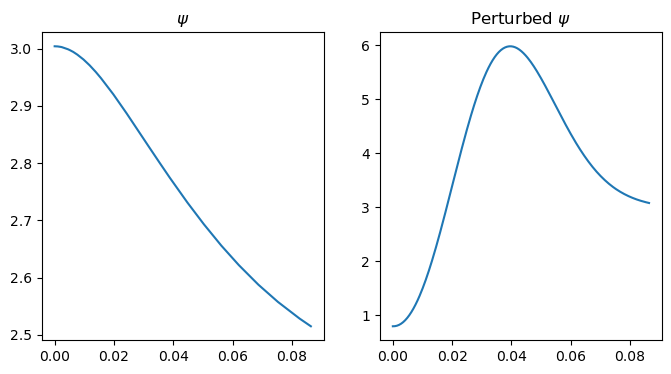

In [120]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
filename    = f'../../data/tov_112.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Interpolate all the data (in oversampled form) to allow for a linear grid
m_intp     = interpolate.interp1d(R, m,     kind='linear', bounds_error=False)
P_intp     = interpolate.interp1d(R, P,     kind='linear', bounds_error=False)
rho_intp   = interpolate.interp1d(R, rho,   kind='linear', bounds_error=False)
alpha_intp = interpolate.interp1d(R, alpha, kind='linear', bounds_error=False)
psi_intp   = interpolate.interp1d(R, psi,   kind='linear', bounds_error=False)

# Convert to linear grid
nb_points = 250
R = np.linspace(np.min(R), np.max(R), nb_points)

m      = m_intp(R)
P      = P_intp(R)
rho    = rho_intp(R)
alpha  = alpha_intp(R)
psi    = psi_intp(R)

# A large perturbation can be used as an initialization of psi
# Perturbation parameters
center_value  = 0.02        # Center value
sigma         = 2*1.0e-2     # Width of the full Gaussian
amplitude     = 4.5e0      # Scale factor

# Construction of the perturbation
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))
psi_perturbation = gaussian * R_centered

# Define the perturbed density
perturbed_psi = psi + psi_perturbation + 0.5

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(R, psi)
ax[0].set_title(r"$\psi$")
ax[1].plot(R, perturbed_psi)
ax[1].set_title(r"Perturbed $\psi$");

## 1. Problem Definition

Given the perturbation on the density, the vector equations are trivially zero.

We focus immediately on the nonlinear ODE:
\begin{equation}
\nabla^{2} \psi = \frac{S_{1}}{\psi} + \frac{S_{7}}{\psi^7}
\end{equation}
which we will solve in an iterative fashion as we will compute $\psi_{(n+1)}$ in iteration $n+1$ based on the previous estimate $\psi_{(n)}$ in iteration $n$:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}} + \frac{S_{7}}{\psi_{(n)}^7}
\end{equation}
Assume we have an initial guess $\psi_{(0)}$, we aim to find $\psi$ density $\rho$. This leads to the source terms:
\begin{align}
    S_1   &= -2 \pi \rho \psi_{(n)}^6 \\ 
    S_7   &= 0 \\
\end{align}
such that the nonlinear ODE now reads:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
In spherical symmetry, this ODE results in:
\begin{equation}
    \big( \partial_{r}^{2} + \frac{2}{r} \partial_r \big) \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
It should satisfy the following boundary conditions:
\begin{align}
    \frac{d\psi}{dr}(0) &= 0 \\
    \psi(R) &= 1 + \frac{C}{2R_{max}} 
\end{align}
For the uncertaint quantification part, see the shared notes.

## 2. Solver with Uncertainty Quantification

In [121]:
# Definition of the source term S1
S1 = - 2*np.pi*rho*psi**6

# Symbol nomenclature
r     = sp.symbols('r')
n     = sp.symbols('n')
R_max = sp.symbols('R_max')

# Definition of the basis functions
basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)

# Definition of the laplacian operator
laplacian = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)



00%|██████████████████████████████████████████| 10/10 [00:00<00:00, 108.80it/s]

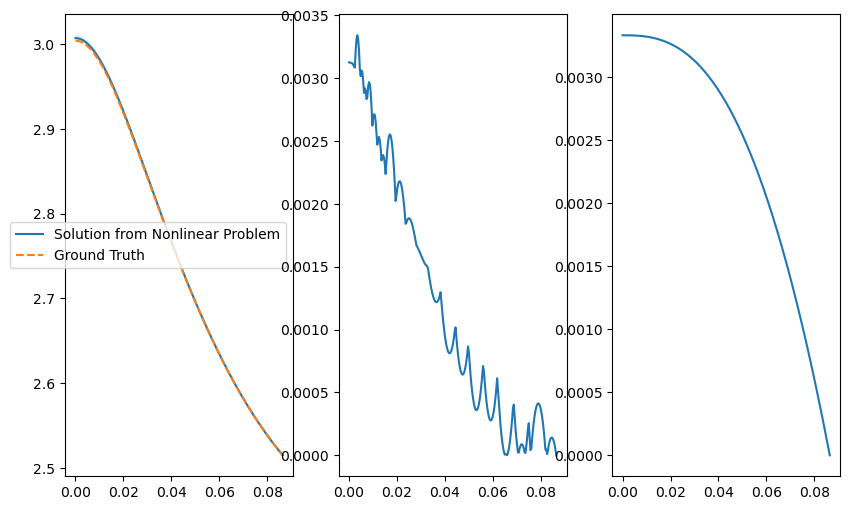

In [122]:
# ==================================================================
# Function definitions
# ================================================================== 

# 1a. Construction of the source term
def construct_source_term(psi):
    return S1 / psi

# 1b. Construction of the design matrix
def construct_design_matrix(R, N, basis_func, laplacian):
    
    # Lambdify the functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    laplacian_lambd  = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

    # Matrix initialization
    basis_func_matrix = np.zeros((len(R), N))
    design_matrix     = np.zeros((len(R), N))

    # Construction of the basis function and design matrix
    # Avoid i = 0, as that result in the zero-function
    for i in range(1, N+1):
        # Regular ODE solution
        basis_func_matrix[:, i-1] = basis_func_lambd(R, i, max(R))
        design_matrix[:, i-1]     = laplacian_lambd(R, i, max(R))

    return basis_func_matrix, design_matrix

# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, observations, prior_mean, prior_prec, likelihood_prec):
    
    # Weight vector: posterior distribution on the weights
    b = design_matrix.T @ likelihood_prec @ observations + np.squeeze(prior_prec @ prior_mean)
    w_posterior_prec_matrix = design_matrix.T @ likelihood_prec @ design_matrix + prior_prec
    w_posterior_mean = np.linalg.solve(w_posterior_prec_matrix, b)

    # Source function: posterior mean and covariance
    source_func_mean = np.squeeze(design_matrix @ w_posterior_mean)
    source_func_covariance_matrix = design_matrix @ np.linalg.solve(w_posterior_prec_matrix, design_matrix.T)
    
    # ODE solution: posterior mean and covariance
    solution_mean = np.squeeze(basis_func_matrix @ w_posterior_mean)
    solution_covariance_matrix = basis_func_matrix @ np.linalg.solve(w_posterior_prec_matrix, basis_func_matrix.T)

    return solution_mean, solution_covariance_matrix, source_func_mean, source_func_covariance_matrix, w_posterior_mean, w_posterior_prec_matrix


# ==================================================================
# Solving the ODE
# ================================================================== 
# Initialization and solver definitions
psi_init                       = perturbed_psi 
iteration_steps                = 10
N                              = 25                 # Number of basis functions
s                              = 10**(5)            # Likelihood variance on S1 in the source term
l                              = 10**(12)           # Prior variance on psi, i.e. the solution

# Conversion to (co-)variance matrices
S                              = s*np.identity(len(R))     
L                              = l*np.identity(N)          

# Definition and initialization of arrays to store evolution of variables
psi_mean_storage               = np.zeros((len(psi), iteration_steps+1))
psi_var_storage                = np.zeros((len(psi), len(psi), iteration_steps+1))
w_mean_storage                 = np.zeros((N, iteration_steps+1))
w_prec_storage                 = np.zeros((N, N, iteration_steps+1))
likelihood_prec_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))
source_term_storage            = np.zeros((len(psi), iteration_steps+1))

psi_mean_storage[:,0]          = psi_init
psi_var_storage[:,:,0]         = 10**2*np.identity(len(psi))
w_mean_storage[:,0]            = np.squeeze(np.zeros((N, 1)))
w_prec_storage[:,:,0]          = np.linalg.inv(L)
likelihood_prec_storage[:,:,0] = np.linalg.inv(S)
source_term_storage[:,0]       = construct_source_term(psi_init)

# Define the basis function and design matrix, and boundary value at R = R_max
basis_func_matrix, design_matrix   = construct_design_matrix(R, N, basis_func, laplacian)
boundary_value                     = psi[-1] 

# Iterative refinement of the ODE solution
for i in tqdm(range(iteration_steps)):
    
    # Call the ODE solver
    solution_mean_primal, solution_variance_primal, _, _, w, w_prec = solve_ode(basis_func_matrix, design_matrix, source_term_storage[:,i], \
                                                                                w_mean_storage[:,i], w_prec_storage[:,:,i], likelihood_prec_storage[:,:,i])

    # Define the Jacobians required for the Gaussian approximation of the likelihood
    Jf_psi = np.diag(-S1/(solution_mean_primal + boundary_value)**2)                                       
    Jf_S   = np.diag(1/(solution_mean_primal + boundary_value))

    # Gaussian approximation of the likelihood precision
    likelihood_prec = np.linalg.inv(Jf_S @ S @ Jf_S.T + Jf_psi @ solution_variance_primal @ Jf_psi.T)
    
    # Store intermediate results
    psi_mean_storage[:, i+1]         = solution_mean_primal
    psi_var_storage[:,:,i+1]         = solution_variance_primal
    w_mean_storage[:,i+1]            = w
    w_prec_storage[:,:,i+1]          = w_prec
    source_term_storage[:,i+1]       = construct_source_term(solution_mean_primal + boundary_value)
    likelihood_prec_storage[:,:,i+1] = likelihood_prec

    
# ==================================================================
# Visualization of the solution
# ================================================================== 
fig, ax = plt.subplots(1,3, figsize=(10,6))

# Ground truth vs. Solution including standard deviation
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0].plot(R, (solution_mean_primal + boundary_value), label="Solution from Nonlinear Problem")
ax[0].fill_between(R, solution_mean_primal + boundary_value - solution_std, solution_mean_primal + boundary_value + solution_std, alpha=0.15)
ax[0].plot(R, psi, ls='--', label="Ground Truth")
ax[0].legend()

# Absolute error
ax[1].plot(R, np.abs(solution_mean_primal + boundary_value - psi))

# Standard deviation
ax[2].plot(R, solution_std);

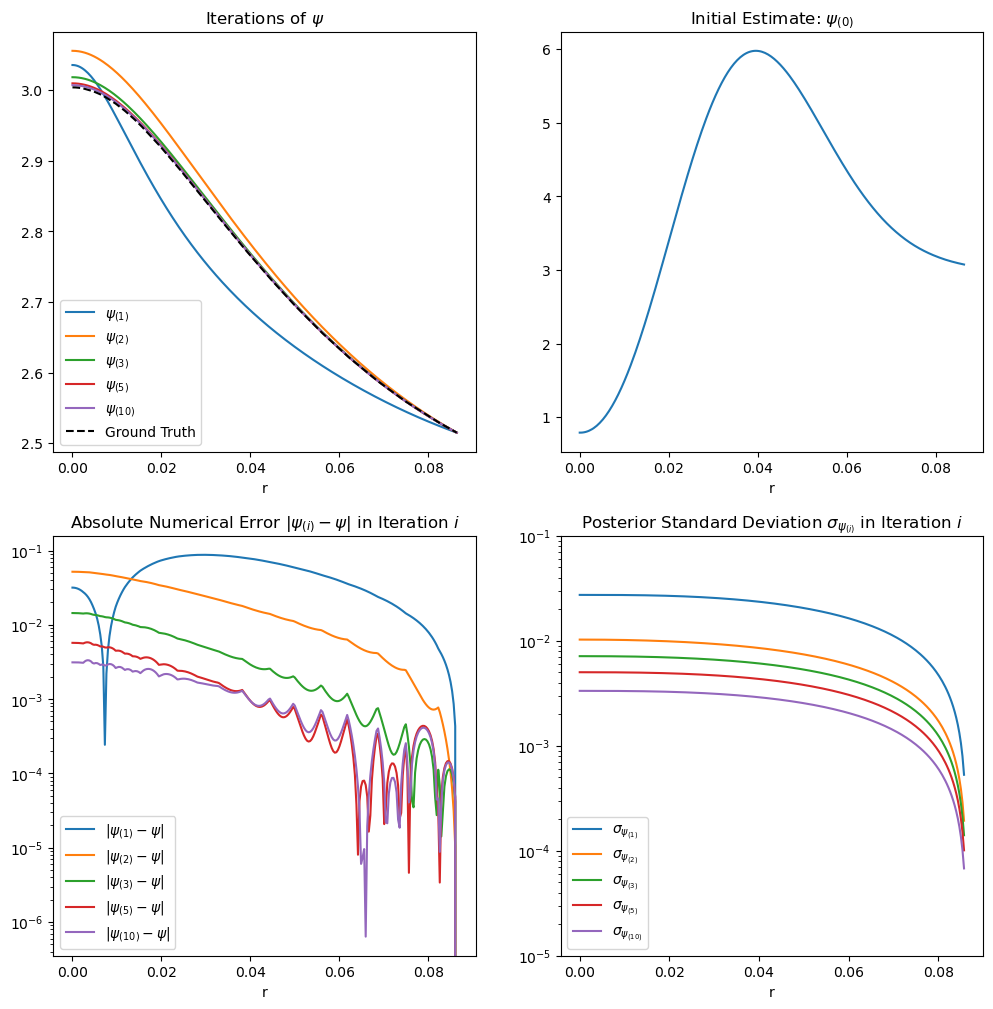

In [123]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# Ground truth vs. Solution including standard deviation
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0, 0].plot(R, psi_mean_storage[:,1] + boundary_value, label=r"$\psi_{(1)}$")
ax[0, 0].plot(R, psi_mean_storage[:,2] + boundary_value, label=r"$\psi_{(2)}$")
ax[0, 0].plot(R, psi_mean_storage[:,3] + boundary_value, label=r"$\psi_{(3)}$")
ax[0, 0].plot(R, psi_mean_storage[:,5] + boundary_value, label=r"$\psi_{(5)}$")
ax[0, 0].plot(R, psi_mean_storage[:,10] + boundary_value, label=r"$\psi_{(10)}$")
ax[0, 0].plot(R, psi, color='black', ls='--', label="Ground Truth")
ax[0, 0].legend(loc='lower left')
ax[0, 0].set_title(r"Iterations of $\psi$")
ax[0, 0].set_xlabel("r")

# Initial estimate
ax[0, 1].plot(R, np.abs(psi_mean_storage[:,0]), label=r"$\psi_{(0)}$")
ax[0, 1].set_title(r"Initial Estimate: $\psi_{(0)}$")
ax[0, 1].set_xlabel("r")

# Absolute error
ax[1, 0].plot(R, np.abs(psi_mean_storage[:,1] + boundary_value - psi), label=r"$|\psi_{(1)} - \psi|$")
ax[1, 0].plot(R, np.abs(psi_mean_storage[:,2] + boundary_value - psi), label=r"$|\psi_{(2)} - \psi|$")
ax[1, 0].plot(R, np.abs(psi_mean_storage[:,3] + boundary_value - psi), label=r"$|\psi_{(3)} - \psi|$")
ax[1, 0].plot(R, np.abs(psi_mean_storage[:,5] + boundary_value - psi), label=r"$|\psi_{(5)} - \psi|$")
ax[1, 0].plot(R, np.abs(psi_mean_storage[:,10] + boundary_value - psi), label=r"$|\psi_{(10)} - \psi|$")
ax[1, 0].set_yscale('log')
ax[1, 0].legend()
ax[1, 0].set_title(r"Absolute Numerical Error $|\psi_{(i)} - \psi|$ in Iteration $i$")
ax[1, 0].set_xlabel("r")

# Standard deviation
e = 2
ax[1, 1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,1])), label=r"$\sigma_{\psi_{(1)}}$")
ax[1, 1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,2])), label=r"$\sigma_{\psi_{(2)}}$")
ax[1, 1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,3])), label=r"$\sigma_{\psi_{(3)}}$")
ax[1, 1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,5])), label=r"$\sigma_{\psi_{(5)}}$")
ax[1, 1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,10])), label=r"$\sigma_{\psi_{(10)}}$")
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylim([10**(-5), 10**(-1)])
ax[1, 1].legend();
ax[1, 1].set_title(r"Posterior Standard Deviation $\sigma_{\psi_{(i)}}$ in Iteration $i$");
ax[1, 1].set_xlabel("r")

fig.savefig("Psi-solution-25.png", format="png", bbox_inches="tight")

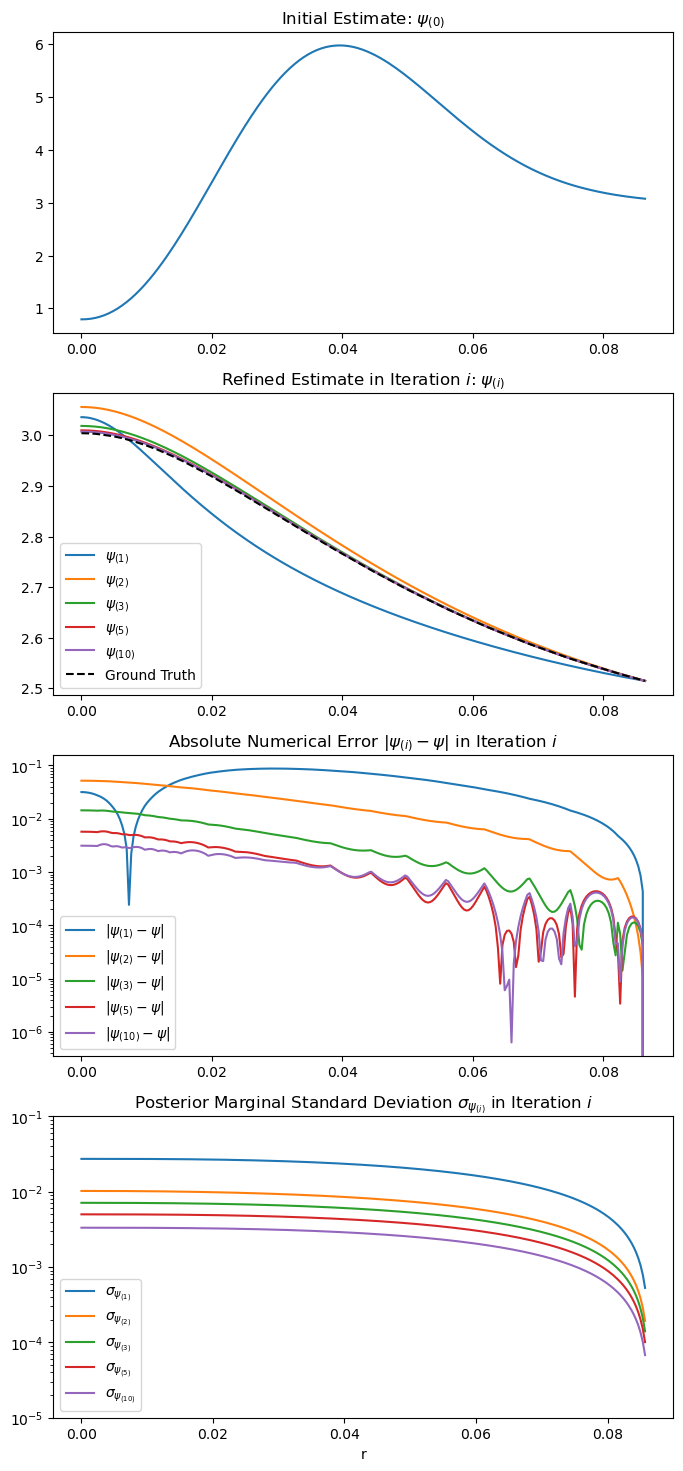

In [124]:
fig, ax = plt.subplots(4, 1, figsize=(8,18))

# Ground truth vs. Solution including standard deviation
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[1].plot(R, psi_mean_storage[:,1] + boundary_value, label=r"$\psi_{(1)}$")
ax[1].plot(R, psi_mean_storage[:,2] + boundary_value, label=r"$\psi_{(2)}$")
ax[1].plot(R, psi_mean_storage[:,3] + boundary_value, label=r"$\psi_{(3)}$")
ax[1].plot(R, psi_mean_storage[:,5] + boundary_value, label=r"$\psi_{(5)}$")
ax[1].plot(R, psi_mean_storage[:,10] + boundary_value, label=r"$\psi_{(10)}$")
ax[1].plot(R, psi, color='black', ls='--', label="Ground Truth")
ax[1].legend(loc='lower left')
ax[1].set_title(r"Refined Estimate in Iteration $i$: $\psi_{(i)}$")
#ax[0].set_xlabel("r")

# Initial estimate
ax[0].plot(R, np.abs(psi_mean_storage[:,0]), label=r"$\psi_{(0)}$")
ax[0].set_title(r"Initial Estimate: $\psi_{(0)}$")
#ax[1].set_xlabel("r")

# Absolute error
ax[2].plot(R, np.abs(psi_mean_storage[:,1] + boundary_value - psi), label=r"$|\psi_{(1)} - \psi|$")
ax[2].plot(R, np.abs(psi_mean_storage[:,2] + boundary_value - psi), label=r"$|\psi_{(2)} - \psi|$")
ax[2].plot(R, np.abs(psi_mean_storage[:,3] + boundary_value - psi), label=r"$|\psi_{(3)} - \psi|$")
ax[2].plot(R, np.abs(psi_mean_storage[:,5] + boundary_value - psi), label=r"$|\psi_{(5)} - \psi|$")
ax[2].plot(R, np.abs(psi_mean_storage[:,10] + boundary_value - psi), label=r"$|\psi_{(10)} - \psi|$")
ax[2].set_yscale('log')
ax[2].legend(loc='lower left')
ax[2].set_title(r"Absolute Numerical Error $|\psi_{(i)} - \psi|$ in Iteration $i$")
#ax[2].set_xlabel("r")

# Standard deviation
e = 2
ax[3].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,1])), label=r"$\sigma_{\psi_{(1)}}$")
ax[3].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,2])), label=r"$\sigma_{\psi_{(2)}}$")
ax[3].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,3])), label=r"$\sigma_{\psi_{(3)}}$")
ax[3].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,5])), label=r"$\sigma_{\psi_{(5)}}$")
ax[3].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,10])), label=r"$\sigma_{\psi_{(10)}}$")
ax[3].set_yscale('log')
ax[3].set_ylim([10**(-5), 10**(-1)])
ax[3].legend();
ax[3].set_title(r"Posterior Marginal Standard Deviation $\sigma_{\psi_{(i)}}$ in Iteration $i$");
ax[3].set_xlabel("r")

fig.savefig("Psi-solution-25-column.png", format="png", bbox_inches="tight")

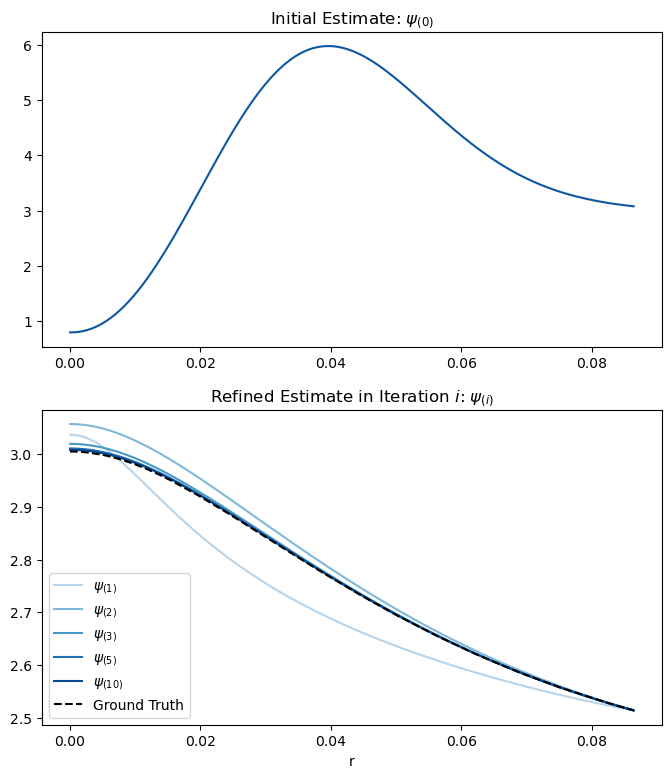

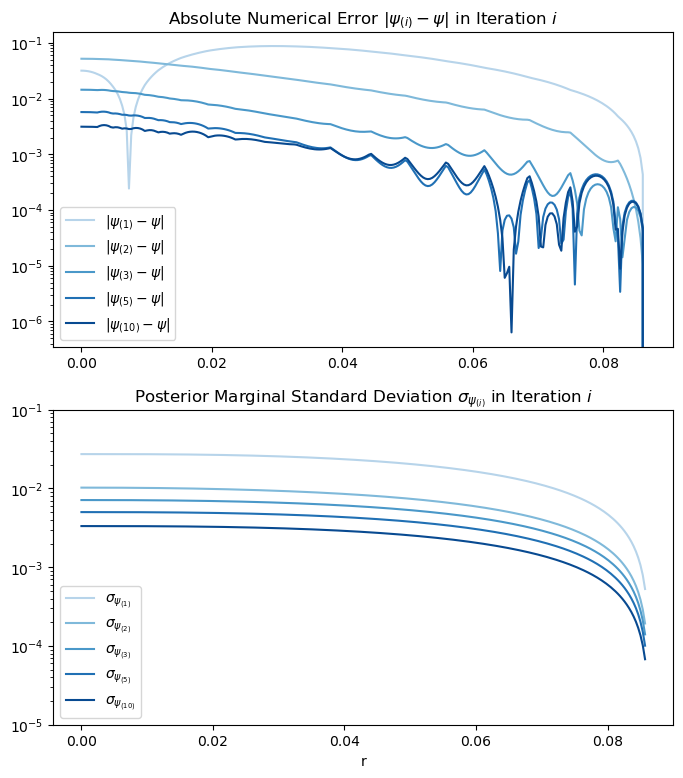

In [125]:
# === FIGURE 1: Estimates ===
fig1, ax1 = plt.subplots(2, 1, figsize=(8, 9))

# Colormap setup
cmap = plt.cm.Blues
iterations = [1, 2, 3, 5, 10]
n = len(iterations)
start, stop = 0.3, 0.9  # Contrast range

# Initial estimate
ax1[0].plot(R, np.abs(psi_mean_storage[:, 0]), label=r"$\psi_{(0)}$", color=cmap(0.85))
ax1[0].set_title(r"Initial Estimate: $\psi_{(0)}$")

# Refined estimates
for idx, i in enumerate(iterations):
    color = cmap(start + (stop - start) * idx / (n - 1))
    ax1[1].plot(R, psi_mean_storage[:, i] + boundary_value,
                label=fr"$\psi_{{({i})}}$", color=color)

ax1[1].plot(R, psi, color='black', ls='--', label="Ground Truth")
ax1[1].legend(loc='lower left')
ax1[1].set_title(r"Refined Estimate in Iteration $i$: $\psi_{(i)}$")
ax1[1].set_xlabel("r")

fig1.savefig("Psi-solution-25-column-1.png", format="png", bbox_inches="tight")

# === FIGURE 2: Error and Standard Deviation ===
fig2, ax2 = plt.subplots(2, 1, figsize=(8, 9))

# Absolute error
for idx, i in enumerate(iterations):
    color = cmap(start + (stop - start) * idx / (n - 1))
    ax2[0].plot(R, np.abs(psi_mean_storage[:, i] + boundary_value - psi),
                label=fr"$|\psi_{{({i})}} - \psi|$", color=color)

ax2[0].set_yscale('log')
ax2[0].legend(loc='lower left')
ax2[0].set_title(r"Absolute Numerical Error $|\psi_{(i)} - \psi|$ in Iteration $i$")

# Standard deviation
e = 2
for idx, i in enumerate(iterations):
    color = cmap(start + (stop - start) * idx / (n - 1))
    ax2[1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e, :-e, i])),
                label=fr"$\sigma_{{\psi_{{({i})}}}}$", color=color)

ax2[1].set_yscale('log')
ax2[1].set_ylim([1e-5, 1e-1])
ax2[1].legend()
ax2[1].set_title(r"Posterior Marginal Standard Deviation $\sigma_{\psi_{(i)}}$ in Iteration $i$")
ax2[1].set_xlabel("r")

fig2.savefig("Psi-solution-25-column-2.png", format="png", bbox_inches="tight")


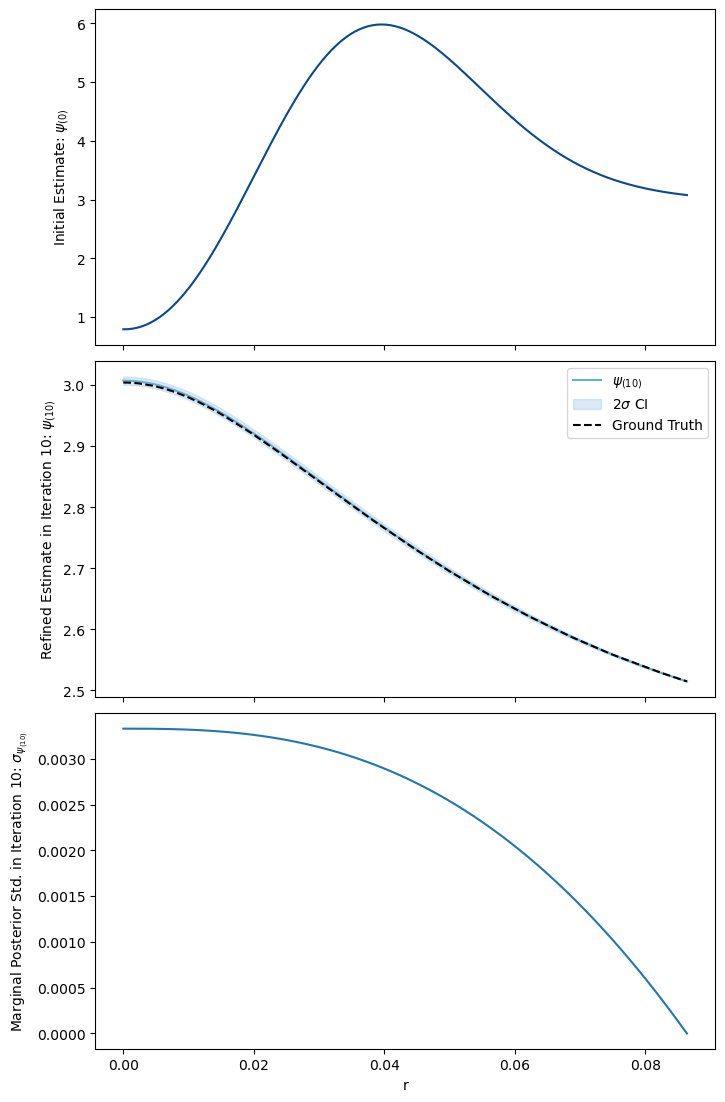

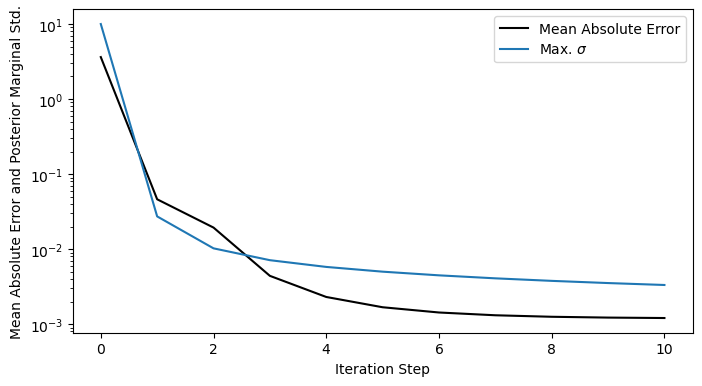

In [149]:
# New format
# === FIGURE 1: Estimates ===
fig1, (ax_top, ax_middle, ax_bottom) = plt.subplots(3, 1, figsize=(8, 13.5), sharex=True)
fig1.subplots_adjust(hspace=0.05)

# Colormap setup
cmap = plt.cm.Blues
iterations = [1, 2, 3, 5, 10]
n = len(iterations)
start, stop = 0.3, 0.9  # Contrast range

# Initial estimate
ax_top.plot(R, np.abs(psi_mean_storage[:, 0]), label=r"$\psi_{(0)}$", color=cmap(0.9))
ax_top.set_ylabel(r"Initial Estimate: $\psi_{(0)}$")

# Refined estimate
ax_middle.plot(R, psi_mean_storage[:, -1] + boundary_value, label=fr"$\psi_{{({i})}}$", color=cmap(0.5))
ax_middle.fill_between(
    R,
    psi_mean_storage[:, -1] + boundary_value - 2*np.sqrt(np.diag(psi_var_storage[:, :, -1])),
    psi_mean_storage[:, -1] + boundary_value + 2*np.sqrt(np.diag(psi_var_storage[:, :, -1])),
    label=r"2$\sigma$ CI",
    color=cmap(0.3), alpha=0.5
)
ax_middle.plot(R, psi, color='black', ls='--', label="Ground Truth")
ax_middle.legend(loc='upper right')
ax_middle.set_ylabel(r"Refined Estimate in Iteration $10$: $\psi_{(10)}$")

# Optional: Turn off x-tick labels on the top plot to declutter
ax_top.label_outer()
ax_middle.label_outer()

ax_bottom.plot(R, np.sqrt(np.diag(psi_var_storage[:, :, -1])))
ax_bottom.set_xlabel("r")
ax_bottom.set_ylabel(r"Marginal Posterior Std. in Iteration $10$: $\sigma_{\psi_{(10)}}$")

fig1.savefig("Psi-solution-25-column-1.png", format="png", bbox_inches="tight")

# === FIGURE 2: Error and Standard Deviation ===
mean_abs_errors = [np.mean(np.abs(psi_mean_storage[:, i] + boundary_value - psi)) for i in range(11)]
e = -2 # to avoid zero on a log plot
max_sigma  = [np.max(np.sqrt(np.diag(psi_var_storage[:-e, :-e, i]))) for i in range(11)]

plt.figure(figsize=(8, 4.2))
plt.plot(range(11), mean_abs_errors, color='black', label='Mean Absolute Error')
plt.plot(range(11), max_sigma, label=r'Max. $\sigma$')
plt.yscale("log")
plt.xlabel("Iteration Step")
plt.ylabel("Mean Absolute Error and Posterior Marginal Std.")
plt.legend()

plt.savefig("Psi-solution-25-column-2.png", format="png", bbox_inches="tight")


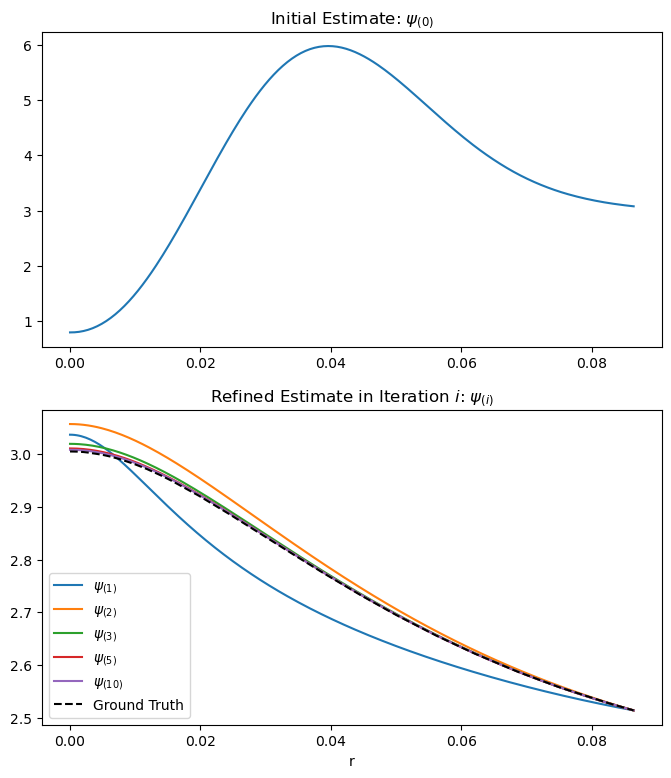

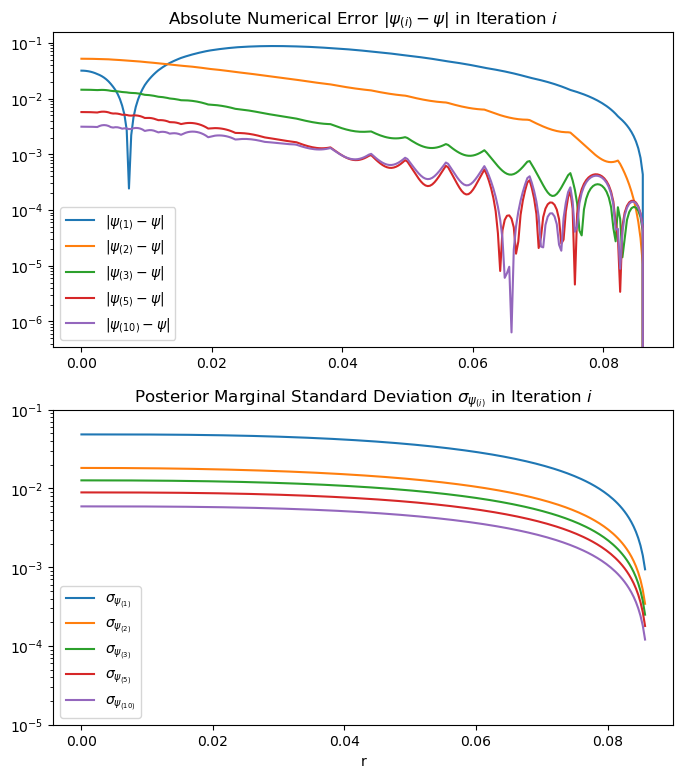

In [8]:
# fig, ax = plt.subplots(2, 1, figsize=(8,9))

# # Ground truth vs. Solution including standard deviation
# solution_std = np.sqrt(np.diag(solution_variance_primal))
# ax[1].plot(R, psi_mean_storage[:,1] + boundary_value, label=r"$\psi_{(1)}$")
# ax[1].plot(R, psi_mean_storage[:,2] + boundary_value, label=r"$\psi_{(2)}$")
# ax[1].plot(R, psi_mean_storage[:,3] + boundary_value, label=r"$\psi_{(3)}$")
# ax[1].plot(R, psi_mean_storage[:,5] + boundary_value, label=r"$\psi_{(5)}$")
# ax[1].plot(R, psi_mean_storage[:,10] + boundary_value, label=r"$\psi_{(10)}$")
# ax[1].plot(R, psi, color='black', ls='--', label="Ground Truth")
# ax[1].legend(loc='lower left')
# ax[1].set_title(r"Refined Estimate in Iteration $i$: $\psi_{(i)}$")
# #ax[0].set_xlabel("r")

# # Initial estimate
# ax[0].plot(R, np.abs(psi_mean_storage[:,0]), label=r"$\psi_{(0)}$")
# ax[0].set_title(r"Initial Estimate: $\psi_{(0)}$")
# ax[1].set_xlabel("r")
# b
# fig.savefig("Psi-solution-25-column-1.png", format="png", bbox_inches="tight")

# fig, ax = plt.subplots(2, 1, figsize=(8,9))

# # Absolute error
# ax[0].plot(R, np.abs(psi_mean_storage[:,1] + boundary_value - psi), label=r"$|\psi_{(1)} - \psi|$")
# ax[0].plot(R, np.abs(psi_mean_storage[:,2] + boundary_value - psi), label=r"$|\psi_{(2)} - \psi|$")
# ax[0].plot(R, np.abs(psi_mean_storage[:,3] + boundary_value - psi), label=r"$|\psi_{(3)} - \psi|$")
# ax[0].plot(R, np.abs(psi_mean_storage[:,5] + boundary_value - psi), label=r"$|\psi_{(5)} - \psi|$")
# ax[0].plot(R, np.abs(psi_mean_storage[:,10] + boundary_value - psi), label=r"$|\psi_{(10)} - \psi|$")
# ax[0].set_yscale('log')
# ax[0].legend(loc='lower left')
# ax[0].set_title(r"Absolute Numerical Error $|\psi_{(i)} - \psi|$ in Iteration $i$")
# #ax[2].set_xlabel("r")

# # Standard deviation
# e = 2
# ax[1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,1])), label=r"$\sigma_{\psi_{(1)}}$")
# ax[1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,2])), label=r"$\sigma_{\psi_{(2)}}$")
# ax[1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,3])), label=r"$\sigma_{\psi_{(3)}}$")
# ax[1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,5])), label=r"$\sigma_{\psi_{(5)}}$")
# ax[1].plot(R[:-e], np.sqrt(np.diag(psi_var_storage[:-e,:-e,10])), label=r"$\sigma_{\psi_{(10)}}$")
# ax[1].set_yscale('log')
# ax[1].set_ylim([10**(-5), 10**(-1)])
# ax[1].legend();
# ax[1].set_title(r"Posterior Marginal Standard Deviation $\sigma_{\psi_{(i)}}$ in Iteration $i$");
# ax[1].set_xlabel("r")

# fig.savefig("Psi-solution-25-column-2.png", format="png", bbox_inches="tight")

## Solver without Uncertainty Propagation


00%|████████████████████████████████████████████| 5/5 [00:00<00:00, 954.73it/s]

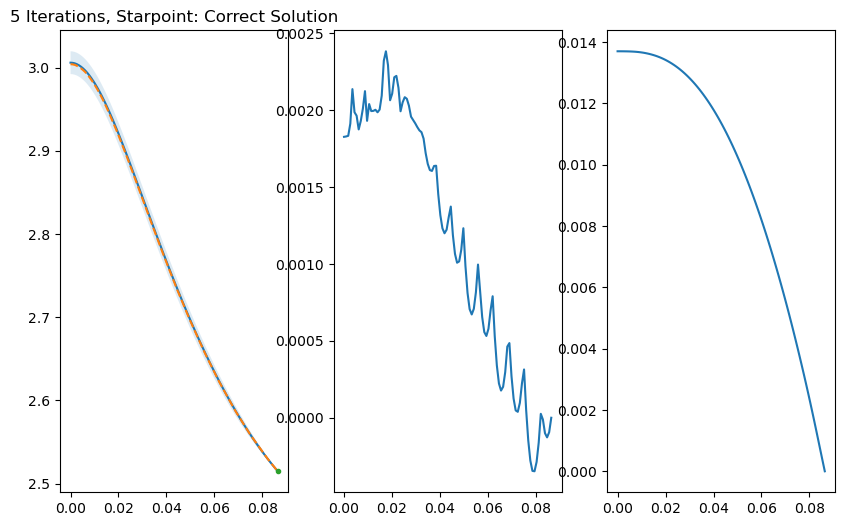

In [5]:
# Function definitions
# 1a. Construction of the source term
def construct_source_term(psi):
    return S1 / psi

# 1b. Construction of the design matrix
def construct_design_matrix(R, N, basis_func, laplacian):
    
    # Lambdify the functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    laplacian_lambd = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

    # Matrix initialization
    basis_func_matrix = np.zeros((len(R), N))
    design_matrix = np.zeros((len(R), N))

    # Construction of the basis function and design matrix
    # Avoid i equal to one as that introduces problems with the sinc function
    for i in range(1, N+1):
        # Regular ODE solution
        basis_func_matrix[:, i-1] = basis_func_lambd(R, i, max(R))
        design_matrix[:,  i-1] = laplacian_lambd(R, i, max(R))

    return basis_func_matrix, design_matrix

# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, observations, likelihood_precision, prior_precision, prior_mean):
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    w_precision_matrix = design_matrix.T @ likelihood_precision @ design_matrix + prior_precision
    b = np.expand_dims(design_matrix.T @ likelihood_precision @ observations, axis=1)

    # Solve the system
    w_mu = np.linalg.solve(w_precision_matrix, b)

    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w_mu
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(w_precision_matrix, design_matrix[:-1,:].T)
    source_func_variance_primal = design_matrix @ v
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w_mu
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(w_precision_matrix, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v

    return solution_mean_primal, solution_variance_primal, source_func_mean_primal, source_func_variance_primal, w_mu, w_precision_matrix
    

psi_init = perturbed_psi 
N = 10                               # Number of basis functions
S = 1.0e4*np.identity(len(R))     # Sigma matrix
L = 1.0e6*np.identity(N)             # 

# Define the arrays which store the variables
iteration_steps        = 5
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))

# Initialization
psi_mean_storage[:, 0] = psi_init

# Boundary condition value
y_BC2 = psi[-1] 

basis_func_matrix, design_matrix = construct_design_matrix(R, N, basis_func, laplacian)
source_term = construct_source_term(psi_init)

for i in tqdm(range(1, iteration_steps + 1)):
    
    # Solve the ODE
    solution_mean_primal, solution_variance_primal, _, _, A, w = solve_ode(basis_func_matrix, design_matrix, source_term, np.linalg.inv(S), np.linalg.inv(L), np.zeros((N, 1)))
    
    # Storage
    psi_mean_storage[:, i] = solution_mean_primal
    psi_var_storage[:,:,i] = solution_variance_primal

    # Construct the new source term
    source_term = construct_source_term(solution_mean_primal + y_BC2)

fig, ax = plt.subplots(1,3, figsize=(10,6))

ax[0].plot(R, solution_mean_primal + y_BC2, label="Solution from Nonlinear Problem")
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0].fill_between(R, solution_mean_primal + y_BC2 - solution_std, solution_mean_primal + y_BC2 + solution_std, alpha=0.15)
ax[0].plot(R, psi, ls='--', label="Ground Truth")
ax[0].plot(np.max(R), y_BC2, marker='.', ls='none', label="Initial Condition")
ax[0].set_title("5 Iterations, Starpoint: Correct Solution")


ax[1].plot(R, solution_mean_primal + y_BC2 - psi)

ax[2].plot(R, solution_std);